## Problem Statement
Demand forecasts are fundamental to plan and deliver products and services. Accurate forecasting of demand can help the manufacturers to maintain appropriate stock which results in reduction in loss due to product not being sold and also reduces the opportunity cost (i.e. higher demand but less availability => opportunity lost). Despite such relevance, manufacturers have difficulty choosing which forecast model is the best for their use case. In this project, historical sales data corresponding to multiple(25) items sold in 10 stores are provided and participants are expected to come up with a best model to predict the future demand for products which results in maximum profit for the manufacturer. Predict the demand for the next 3 months at the item level (i.e. all the stores combined).

## Data
The historical sales data is available here. The item, store and sales details are provided at the daily level for a period spanning 4 years. 

## Minimum Requirements
The end objective of the participant is to produce a model that gives the best prediction to the manufacturer. Such a model must include the seasonality of the items sold.

## Imports

In [1]:
# Data manipution and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Cross Validation
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

# Evaluation
from sklearn.metrics import r2_score, mean_squared_error
import math

## Import the dataset

In [2]:
df = pd.read_csv(r'D:\Data Science\Guvi\Final Project\dataset\train 2.csv')

In [3]:
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [4]:
df.shape

(913000, 4)

In [5]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


## Data Wrangling and Data Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
# date column is in object data-type. Converting that into date datatype
df['date'] = pd.to_datetime(df['date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [9]:
# Checking for null values
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

There are no missing values.

#### we dont need store column to predict demand of the product as we dont need to know which store sells which products most. We only need to know how many products are selling in all of the stores. Which is given by sum of sales of particular product in all the stores.

### Sum of all the sales from all the stores

In [10]:
df = df.groupby(['item', 'date'], as_index=False)['sales'].agg({'sales':'sum'})

In [11]:
df

,item,date,sales
0,1,2013-01-01,133
1,1,2013-01-02,99
2,1,2013-01-03,127
3,1,2013-01-04,145
4,1,2013-01-05,149
...,...,...,...
91295,50,2017-12-27,511
91296,50,2017-12-28,587
91297,50,2017-12-29,596
91298,50,2017-12-30,612


#### We have to predict the demand for every 3 months. So we have to convert the data into rolling 3 months

### Creating a rolling sum of 90 days(3 months)

In [12]:
for i in range(1, 51):
    df.loc[df['item'].isin([i]), 'sales'] = df.loc[df['item'].isin([i]), 'sales'].rolling(90, center=True, min_periods=1).sum().fillna(0)

In [13]:
# df = x

In [14]:
df

,item,date,sales
0,1,2013-01-01,5712.0
1,1,2013-01-02,5832.0
2,1,2013-01-03,5986.0
3,1,2013-01-04,6165.0
4,1,2013-01-05,6272.0
...,...,...,...
91295,50,2017-12-27,31899.0
91296,50,2017-12-28,31002.0
91297,50,2017-12-29,30365.0
91298,50,2017-12-30,29664.0


### Creating Features with date column

In [15]:
df['year'] = df['date'].dt.year
df['month']= df['date'].dt.month
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.week
df['day_of_week'] = df['date'].dt.day_of_week
df['day_of_year'] = df['date'].dt.day_of_year
df['day_in_month'] = df['date'].dt.days_in_month
df['quarter'] = df['date'].dt.quarter
df['is_leap_year'] = df['date'].dt.is_leap_year
df['is_month_start'] = df['date'].dt.is_month_start
df['is_month_end'] = df['date'].dt.is_month_end
df['is_quarter_start'] = df['date'].dt.is_quarter_start
df['is_quarter_end'] = df['date'].dt.is_quarter_end
df['is_year_start'] = df['date'].dt.is_year_start
df['is_year_end'] = df['date'].dt.is_year_end

C:\Users\Praveen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [16]:
df.head()

,item,date,sales,year,month,day,week,day_of_week,day_of_year,day_in_month,quarter,is_leap_year,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,1,2013-01-01,5712.0,2013,1,1,1,1,1,31,1,False,True,False,True,False,True,False
1,1,2013-01-02,5832.0,2013,1,2,1,2,2,31,1,False,False,False,False,False,False,False
2,1,2013-01-03,5986.0,2013,1,3,1,3,3,31,1,False,False,False,False,False,False,False
3,1,2013-01-04,6165.0,2013,1,4,1,4,4,31,1,False,False,False,False,False,False,False
4,1,2013-01-05,6272.0,2013,1,5,1,5,5,31,1,False,False,False,False,False,False,False


In [17]:
# Encoding
df['is_leap_year'] = (df['is_leap_year']==True).astype(int)
df['is_month_start'] = (df['is_month_start']==True).astype(int)
df['is_month_end'] = (df['is_month_end']==True).astype(int)
df['is_quarter_start'] = (df['is_quarter_start']==True).astype(int)
df['is_quarter_end'] = (df['is_quarter_end']==True).astype(int)
df['is_year_start'] = (df['is_year_start']==True).astype(int)
df['is_year_end'] = (df['is_year_end']==True).astype(int)

In [18]:
df.head()

,item,date,sales,year,month,day,week,day_of_week,day_of_year,day_in_month,quarter,is_leap_year,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,1,2013-01-01,5712.0,2013,1,1,1,1,1,31,1,0,1,0,1,0,1,0
1,1,2013-01-02,5832.0,2013,1,2,1,2,2,31,1,0,0,0,0,0,0,0
2,1,2013-01-03,5986.0,2013,1,3,1,3,3,31,1,0,0,0,0,0,0,0
3,1,2013-01-04,6165.0,2013,1,4,1,4,4,31,1,0,0,0,0,0,0,0
4,1,2013-01-05,6272.0,2013,1,5,1,5,5,31,1,0,0,0,0,0,0,0


## Exploratory Data Analysis

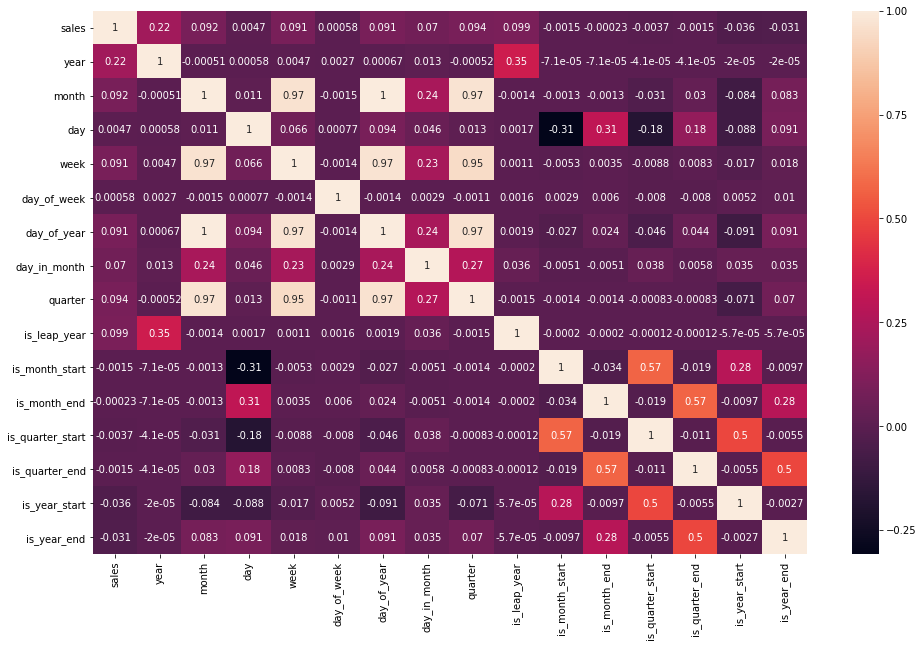

In [19]:
# Heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(data=df[['sales', 'year', 'month', 'day', 'week', 'day_of_week', 'day_of_year', 'day_in_month', 'quarter', 'is_leap_year', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end']].corr(),annot=True)

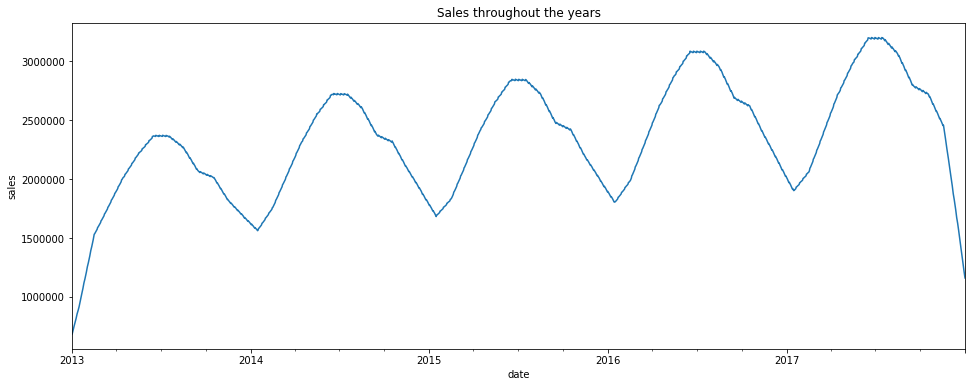

In [20]:
# Sales throughout the years
plt.figure(figsize=(16, 6))
df.set_index('date')['sales'].groupby('date').sum().plot(kind='line')
plt.title('Sales throughout the years')
plt.ylabel('sales')
plt.show()

- The sales of all the 50 products, at the start and end of the year is comparatively less than the middle of the year(Demand is high in the middle of the year).
- The demand of the products are increasing year by year in a cyclic manner.

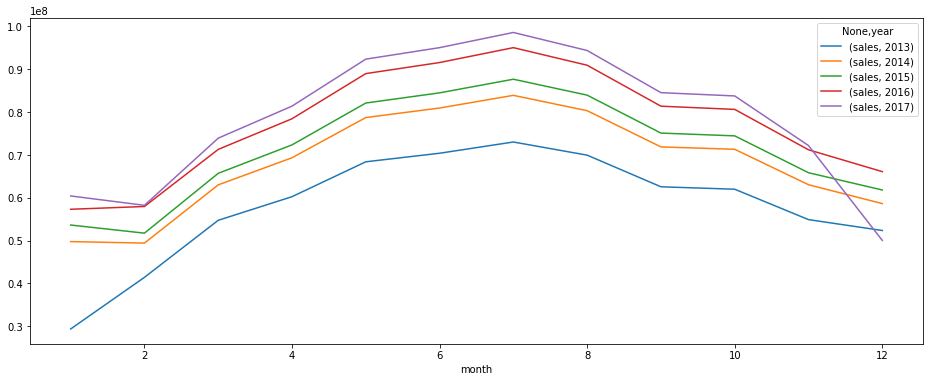

In [21]:
df.groupby(['month', 'year']).agg({'sales':'sum'}).unstack().plot(kind='line', figsize=(16, 6))

- We can see that, at each year the sales are increasing. [In year 2017, there is no data available at the end quarter. So, the decline in line]

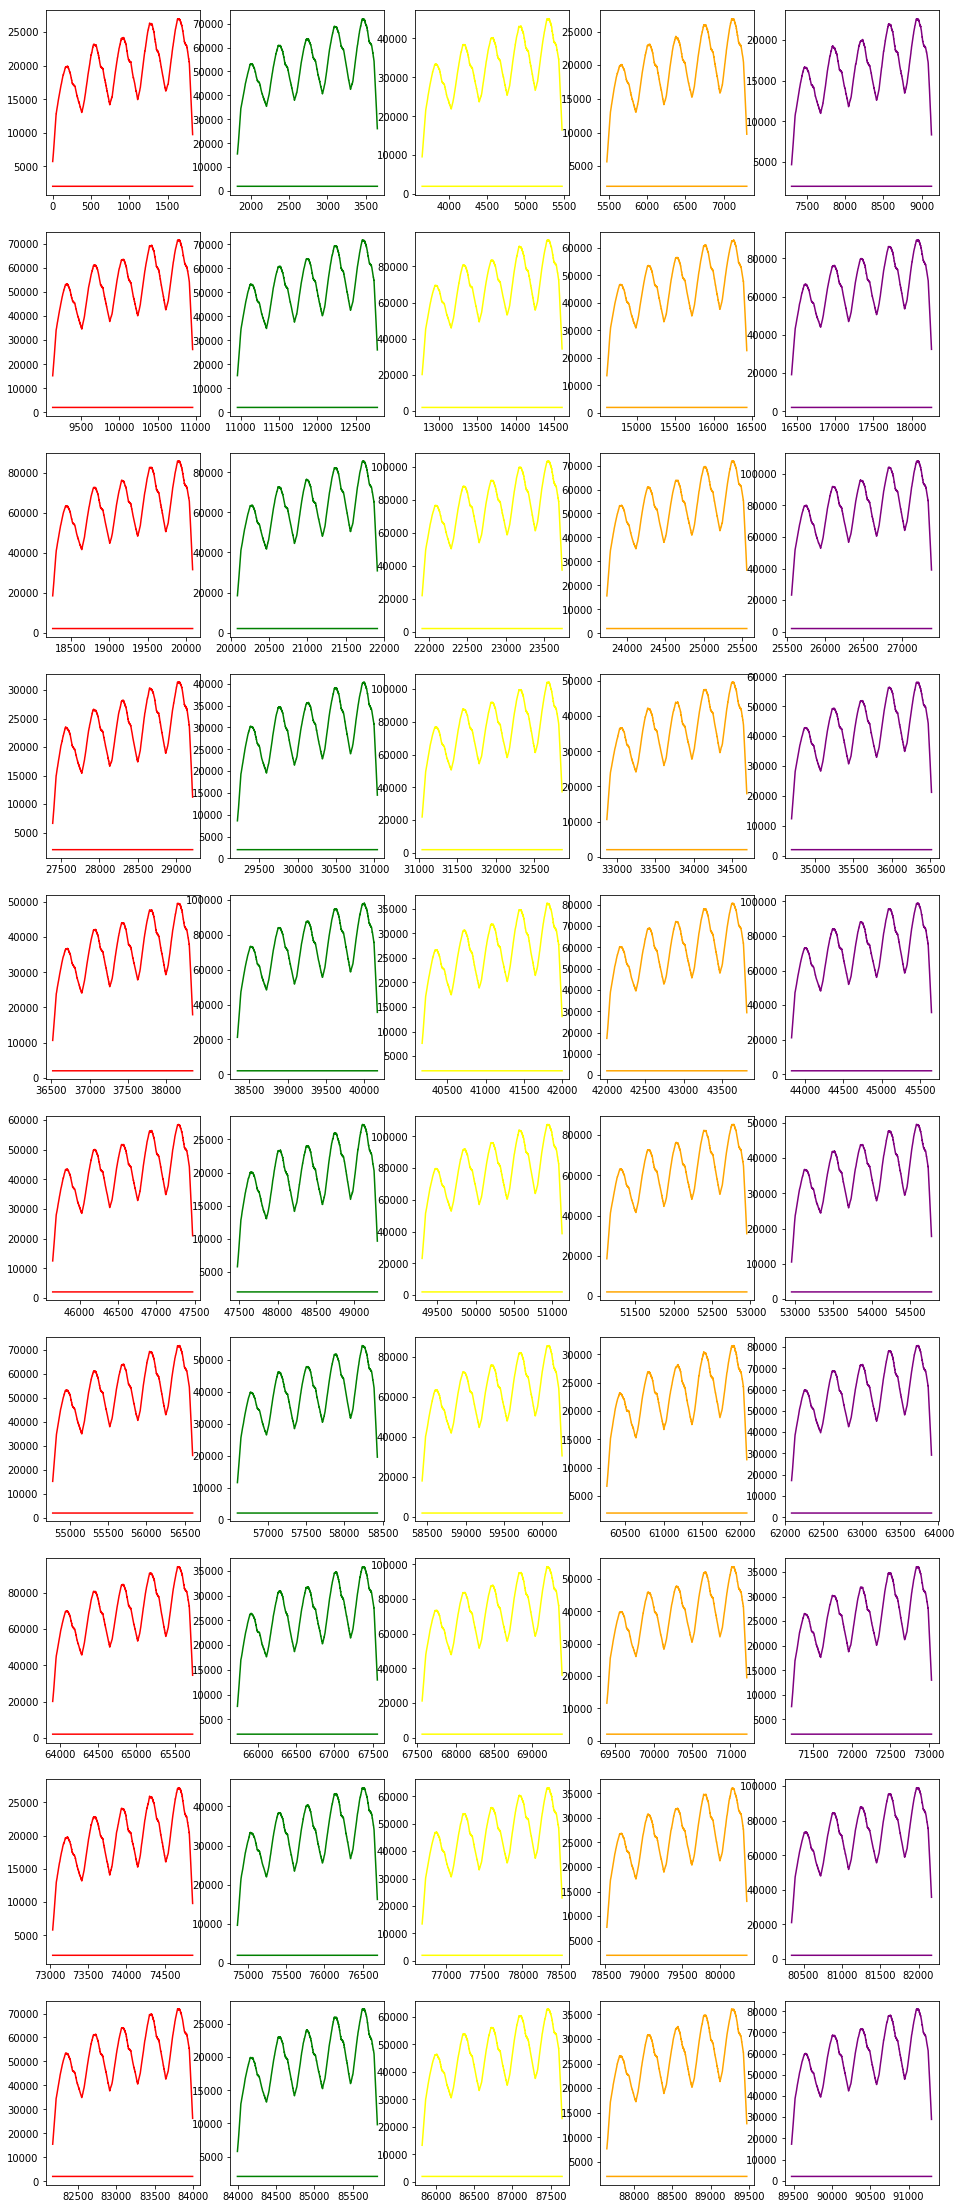

In [22]:
# Sales of each item through out the years
c = ['red', 'green', 'yellow', 'orange', 'purple']
fig, axs = plt.subplots(10, 5, figsize=(16, 40))
k = 0
for i in range(10):
    for j in range(5):
        k += 1
        axs[i, j].plot(df[['year', 'sales']][df['item']==k], color=c[j])

- The sales of each item is so similar. All the item's demand is increasing steadly throughout the years. The way, the items demand increases is same for all the items.
- Eventhough the demand pattern is same for all the products, we can say that the product which is sold the most, years ago is the product that is going to be sold more in the upcoming years too, compared to all the other items.

## Splitting into train and test

In [23]:
df_train = df[df['year']!=2017].reset_index(drop=True)
df_test = df[df['year']==2017].reset_index(drop=True)

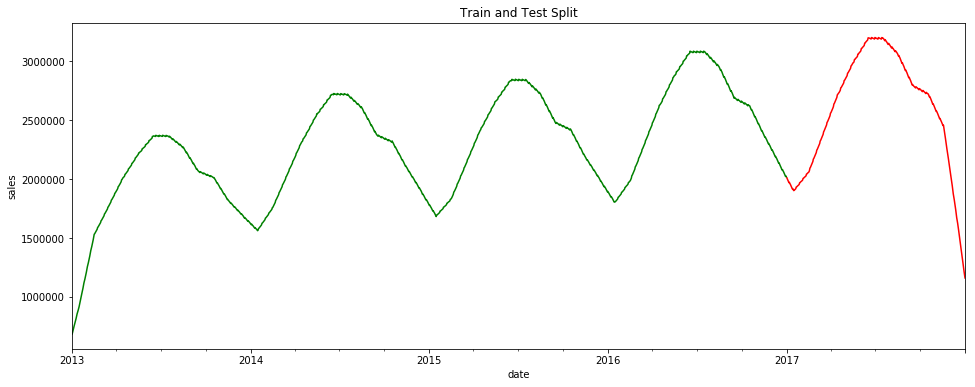

In [24]:
plt.figure(figsize=(16, 6))
df_train.set_index('date')['sales'].groupby('date').sum().plot(kind='line', color='green')
df_test.set_index('date')['sales'].groupby('date').sum().plot(kind='line', color='red')
plt.title('Train and Test Split')
plt.ylabel('sales')
plt.show()

### Creating split for ml model

In [25]:
df.head()

,item,date,sales,year,month,day,week,day_of_week,day_of_year,day_in_month,quarter,is_leap_year,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,1,2013-01-01,5712.0,2013,1,1,1,1,1,31,1,0,1,0,1,0,1,0
1,1,2013-01-02,5832.0,2013,1,2,1,2,2,31,1,0,0,0,0,0,0,0
2,1,2013-01-03,5986.0,2013,1,3,1,3,3,31,1,0,0,0,0,0,0,0
3,1,2013-01-04,6165.0,2013,1,4,1,4,4,31,1,0,0,0,0,0,0,0
4,1,2013-01-05,6272.0,2013,1,5,1,5,5,31,1,0,0,0,0,0,0,0


In [26]:
x_train = df_train.drop(['date', 'sales'], axis=1).values
x_test = df_test.drop(['date', 'sales'], axis=1).values

In [27]:
y_train = df_train['sales'].values
y_test = df_test['sales'].values

## Scaling

In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit_transform(x_train)
sc.fit(x_test)

StandardScaler()

In [29]:
x_train

array([[   1, 2013,    1, ...,    0,    1,    0],
       [   1, 2013,    1, ...,    0,    0,    0],
       [   1, 2013,    1, ...,    0,    0,    0],
       ...,
       [  50, 2016,   12, ...,    0,    0,    0],
       [  50, 2016,   12, ...,    0,    0,    0],
       [  50, 2016,   12, ...,    1,    0,    1]], dtype=int64)

## Model

### Linear Regression

In [30]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [31]:
r2_score(y_test, lr.predict(x_test))

0.027830470315380995

### K Nearest Neighbors

In [32]:
knn = KNeighborsRegressor()
knn.fit(x_train, y_train)

KNeighborsRegressor()

In [33]:
r2_score(y_test, knn.predict(x_test))

0.5998218632221795

### Decision Tree

In [34]:
dt = DecisionTreeRegressor()
dt.fit(x_train, y_train)

DecisionTreeRegressor()

In [35]:
r2_score(y_test, dt.predict(x_test))

0.9486677304237696

### Random Forest

In [36]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)

RandomForestRegressor()

In [37]:
r2_score(y_test, rf.predict(x_test))

0.9511746457921718

### XGBoost

In [38]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [39]:
r2_score(y_test, xgb.predict(x_test))

0.9683700431947907

## Time Series Cross Validation

Plan : 
- Using two years of data for initial training and the initial test set will be next half year.
- In the next iteration, concat the data used for testing with a training set. And use the next six months as a test set.
- And repeat these steps until the last test set is used.

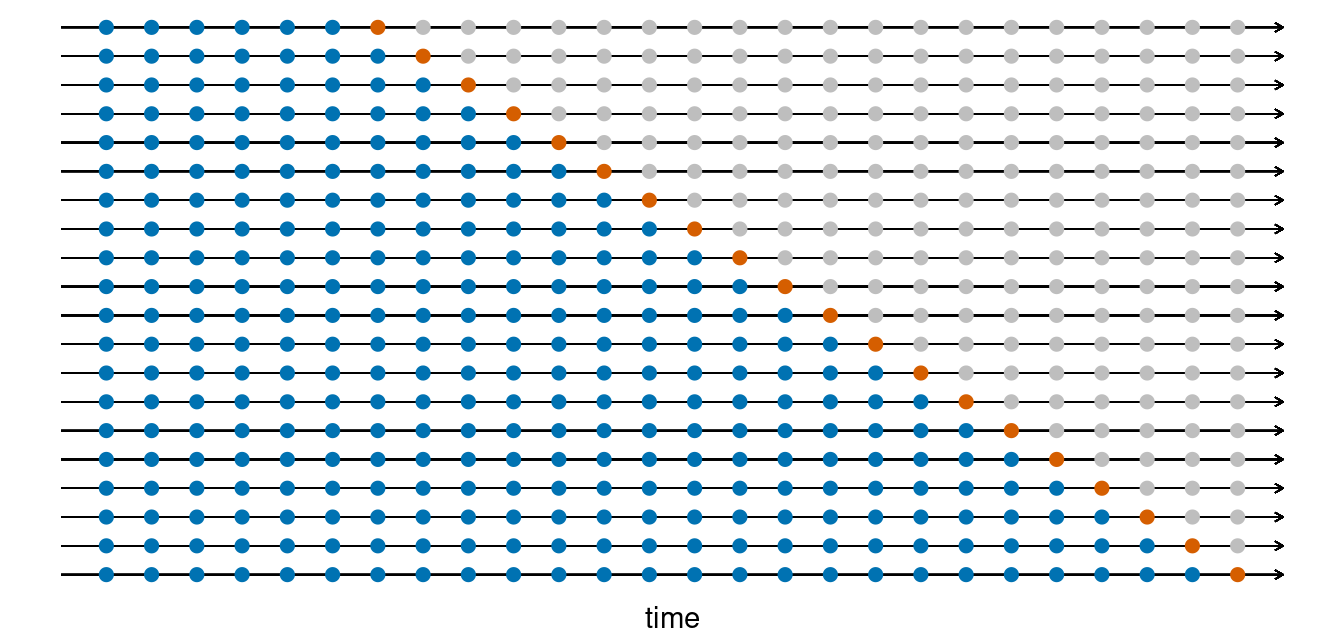

In [40]:
from IPython import display
display.Image("C:/Users/Praveen/Final Project Guvi/Item Demand Forecasting/tscv.png")

In [41]:
df_train['year'].unique()

array([2013, 2014, 2015, 2016], dtype=int64)

In [42]:
def timeseriescv(model):
    
    '''Used to do time series cross validation with given regressor model.
    R2 Score is used for Evaluation and the mean score of 4 validation in time series data will be the output.
    model --> The model we use for cross validation. Ex: XGBregressor()'''
    
    ## Creating first split for time series cross validation
    # Initially using data of 2013 and 2014 as training and the data of next 6 months after the year 2014 is used as a test
    tsdf_train = df_train[df_train['year'].isin([2013, 2014])]
    tsdf_test = df_train[~df_train['year'].isin([2013, 2014])]

    # Creating split for model
    tsx_train = tsdf_train.drop(['sales', 'date'], axis=1).values
    tsy_train = tsdf_train['sales'].values

    tsx_test = tsdf_test[(tsdf_test['year']==2015) & (tsdf_test['month'].isin([1, 2, 3, 4, 5, 6]))].drop(['sales', 'date'], axis=1).reset_index(drop=True).values
    tsy_test = tsdf_test[(tsdf_test['year']==2015) & (tsdf_test['month'].isin([1, 2, 3, 4, 5, 6]))]['sales'].reset_index(drop=True).values
    
    score_list = []
    y = [2015, 2016, 2016]
    
    for i in range(3):
    
        ## model and score appendation
        model = model
        model.fit(tsx_train, tsy_train)
        score_list.append(r2_score(tsy_test, model.predict(tsx_test)))
    
        ## updating split
        tsx_train = pd.concat([pd.DataFrame(tsx_train), pd.DataFrame(tsx_test)], ignore_index=True).values
        tsy_train = pd.concat([pd.DataFrame(tsy_train), pd.DataFrame(tsy_test)], ignore_index=True).values
        if i%2==0:
            m = [7, 8, 9, 10, 11, 12]
        else:
            m = [1, 2, 3, 4, 5, 6,]
        tsx_test = df_train[(df_train['year']==y[i]) & (df_train['month'].isin(m))].drop(['sales', 'date'], axis=1).reset_index(drop=True).values
        tsy_test = df_train[(df_train['year']==y[i]) & (df_train['month'].isin(m))]['sales'].reset_index(drop=True).values

    ## Cross_validation Score
    return np.mean(score_list)

## Decision Tree with Cross Validation

In [43]:
d, m_score = 0, 0
for i in range(3, 40):
    res = timeseriescv(DecisionTreeRegressor(max_depth=i))
    if res>m_score:
        d, m_score = i, res
print(f'max_score: {m_score} and max_depth: {d}')

max_score: 0.9786921790350802 and max_depth: 32


In [44]:
dt = DecisionTreeRegressor(max_depth=32)
dt.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=32)

In [45]:
r2_score(y_test, dt.predict(x_test))

0.9374843135160782

## XGBoost with Cross Validation

In [46]:
# m_score, lrv, mdv, mcwv, ssv, cbv, nev = 0, 0, 0, 0, 0, 0, 0
# lr = [0.01, 0.1, 0.5, 0.8, 0.9, 1]
# md = [10, 15, 20, 21, 22, 23, 24, 25]
# mcw = [1, 3, 5]
# ss = [0.5, 0.7]
# cb = [0.5, 0.7]
# ne = [100, 200, 500]
# for i in range(len(lr)):
#     for j in range(len(md)):
#         for k in range(len(mcw)):
#             for l in range(len(ss)):
#                 for m in range(len(cb)):
#                     for n in range(len(ne)):
#                         res = timeseriescv(XGBRegressor(learning_rate=lr[i], max_depth=md[j], min_child_weight=mcw[k], subsample=ss[l], colsample_bytree=cb[m], n_estimators=ne[n]))
#                         if res>m_score:
#                             m_score = res
#                             lrv, mdv, mcwv, ssv, cbv, nev = lr[i], md[j], mcw[k], ss[l], cb[m], ne[n]
# print(f'max_score: {m_score}, learning_rate: {lrv}, max_depth: {mdv}, min_child_weight: {mcwv},\
# subsample: {ssv}, colsample_bytree: {cbv}, n_estimators: {nev}')

In [47]:
# max_score: 0.9815136016673467, learning_rate: 0.8, max_depth: 22, min_child_weight: 5,subsample: 0.7, colsample_bytree: 0.7, n_estimators: 500

In [48]:
xgb = XGBRegressor(learning_rate=0.8, max_depth=22, min_child_weight=5, subsample=0.7, colsample_bytree=0.7, n_estimators=500)
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.8, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=22, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [49]:
r2_score(y_test, xgb.predict(x_test))

0.9670246067376316

## Important Features

In [50]:
columns = df_train.drop(['date', 'sales'], axis=1).columns

In [51]:
xgb.feature_importances_

array([5.5570304e-01, 1.2573825e-01, 3.0153008e-02, 1.3404317e-03,
       4.9373740e-03, 4.7605595e-04, 2.6620775e-01, 3.1225802e-03,
       4.4393346e-05, 8.3288290e-03, 5.6475011e-04, 5.3622940e-04,
       1.6987210e-04, 5.3267006e-04, 1.4721033e-03, 6.7267613e-04],
      dtype=float32)

In [52]:
imp_feat = pd.DataFrame({'ft':columns, 'imp':xgb.feature_importances_})
imp_feat.sort_values('imp', ascending=False, inplace=True)

In [67]:
imp_feat.iloc[:9, 0].values

array(['item', 'day_of_year', 'year', 'month', 'is_leap_year', 'week',
       'day_in_month', 'is_year_start', 'day'], dtype=object)

In [68]:
print(list(columns))

['item', 'year', 'month', 'day', 'week', 'day_of_week', 'day_of_year', 'day_in_month', 'quarter', 'is_leap_year', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end']


In [55]:
list(pd.DataFrame(x_train).columns)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [56]:
# item - 0, day_of_year - 6, year - 1, month - 2, is_leap_year - 9, day_in_month - 7

In [57]:
imp_fts_data = pd.DataFrame(x_train).loc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8]]
imp_fts_data = imp_fts_data.values

In [58]:
imp_fts_test = pd.DataFrame(x_test).loc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8]].values

In [59]:
imp_fts_data

array([[   1, 2013,    1, ...,    1,   31,    1],
       [   1, 2013,    1, ...,    2,   31,    1],
       [   1, 2013,    1, ...,    3,   31,    1],
       ...,
       [  50, 2016,   12, ...,  364,   31,    4],
       [  50, 2016,   12, ...,  365,   31,    4],
       [  50, 2016,   12, ...,  366,   31,    4]], dtype=int64)

In [60]:
imp_fts_test

array([[   1, 2017,    1, ...,    1,   31,    1],
       [   1, 2017,    1, ...,    2,   31,    1],
       [   1, 2017,    1, ...,    3,   31,    1],
       ...,
       [  50, 2017,   12, ...,  363,   31,    4],
       [  50, 2017,   12, ...,  364,   31,    4],
       [  50, 2017,   12, ...,  365,   31,    4]], dtype=int64)

In [64]:
# learning_rate=0.8, max_depth=22, min_child_weight=5, subsample=0.7, colsample_bytree=0.7, n_estimators=500

In [65]:
xgbif = XGBRegressor(learning_rate=0.8, max_depth=22, min_child_weight=5, subsample=0.7, colsample_bytree=0.7, n_estimators=500)
xgbif.fit(imp_fts_data, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.8, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=22, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [66]:
r2_score(y_test, xgbif.predict(imp_fts_test))

0.9669854066610344